In [1]:
! pip install torch transformers sentence-transformers faiss-cpu datasets scikit-learn numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 43.6 MB/s eta 0:00:00


In [2]:
import math
import random
from dataclasses import dataclass
from typing import List, Dict
import numpy as np
import torch
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
import faiss
from sklearn.metrics import roc_auc_score, roc_curve


# ============================================================
# 0. CONFIG
# ============================================================

@dataclass
class RAGConfig:
    # Small instruction-following model (lightweight)
    llm_name: str = "google/flan-t5-small"
    # Retriever (embedding model)
    retriever_model: str = "sentence-transformers/all-MiniLM-L6-v2"
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    top_k: int = 2
    max_new_tokens: int = 64
    seed: int = 42


@dataclass
class AttackConfig:
    # Make everything small so Colab can handle it
    num_members_in_kb: int = 300       # size of KB (D)
    num_eval_members: int = 50         # members to test MIA on
    num_eval_nonmembers: int = 50      # non-members to test MIA on
    target_fpr: float = 0.05           # e.g., 5% FPR for threshold


# ============================================================
# 1. UTILS
# ============================================================

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    a_norm = a / (np.linalg.norm(a) + 1e-8)
    b_norm = b / (np.linalg.norm(b) + 1e-8)
    return float(np.dot(a_norm, b_norm))


def best_threshold_at_fpr(scores: np.ndarray,
                          labels: np.ndarray,
                          target_fpr: float = 0.01) -> float:
    """
    Choose threshold that gives the highest TPR with FPR <= target_fpr,
    using the ROC curve.
    """
    fpr, tpr, thresholds = roc_curve(labels, scores)
    idx = np.where(fpr <= target_fpr)[0]
    if len(idx) == 0:
        # No point satisfies fpr <= target_fpr, just take the most strict threshold
        return thresholds[0]
    best_idx = idx[np.argmax(tpr[idx])]
    return thresholds[best_idx]


# ============================================================
# 2. DATA LOADING & SPLIT (AgNews)
# ============================================================

def load_agnews_for_rag(max_samples: int = 2000) -> List[Dict]:
    """
    Load a subset of AgNews and split each text into (query, answer).
    We only use the first `max_samples` rows to keep it light.
    """
    print("[Main] Loading AgNews samples...")
    dataset = load_dataset("fancyzhx/ag_news", split=f"train[:{max_samples}]")

    samples = []
    for item in dataset:
        text = item["text"]
        words = text.split()
        if len(words) < 10:
            continue
        mid = len(words) // 2
        q = " ".join(words[:mid])
        a = " ".join(words[mid:])
        samples.append({"query": q, "answer": a})

    print(f"[Main] Total usable samples: {len(samples)}")
    return samples


def split_for_attack(samples: List[Dict], cfg: AttackConfig):
    """
    Simple split:
    - First num_members_in_kb -> KB members
    - Next num_eval_members -> eval members (subset of KB)
    - Next num_eval_nonmembers -> eval non-members (not in KB)
    """
    assert len(samples) > cfg.num_members_in_kb + cfg.num_eval_members + cfg.num_eval_nonmembers

    random.shuffle(samples)

    kb_members = samples[:cfg.num_members_in_kb]

    offset = cfg.num_members_in_kb
    eval_members = kb_members[:cfg.num_eval_members]

    eval_nonmembers = samples[offset:offset + cfg.num_eval_nonmembers]

    return kb_members, eval_members, eval_nonmembers


# ============================================================
# 3. RAG SYSTEM
# ============================================================

class RAGSystem:
    """
    A small RAG:
    - Retriever: MiniLM embeddings + FAISS
    - LLM: Flan-T5-small (text2text-generation) for answers
    """

    def __init__(self, config: RAGConfig, kb_samples: List[Dict]):
        self.cfg = config

        # 1) Retriever model
        print("[RAG] Loading retriever model...")
        self.retriever = SentenceTransformer(self.cfg.retriever_model, device=self.cfg.device)

        # 2) Build KB embeddings
        print("[RAG] Building KB embeddings...")
        self.kb_texts = [s["answer"] for s in kb_samples]
        self.kb_embeddings = self.retriever.encode(
            self.kb_texts,
            show_progress_bar=True,
            convert_to_numpy=True
        )

        d = self.kb_embeddings.shape[1]

        # Normalize for cosine similarity with inner product
        faiss.normalize_L2(self.kb_embeddings)
        self.index = faiss.IndexFlatIP(d)
        self.index.add(self.kb_embeddings)

        # 3) LLM (Flan-T5)
        print("[RAG] Loading LLM (Flan-T5-small)...")
        self.tokenizer = AutoTokenizer.from_pretrained(self.cfg.llm_name)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(self.cfg.llm_name).to(self.cfg.device)
        self.generator = pipeline(
            "text2text-generation",
            model=self.model,
            tokenizer=self.tokenizer,
            device=0 if self.cfg.device == "cuda" else -1
        )

        # Reuse retriever as similarity embedder
        self.sim_embedder = self.retriever

    def retrieve(self, query: str, top_k: int = None):
        if top_k is None:
            top_k = self.cfg.top_k
        q_emb = self.retriever.encode([query], convert_to_numpy=True)
        faiss.normalize_L2(q_emb)
        D, I = self.index.search(q_emb, top_k)
        retrieved = [self.kb_texts[i] for i in I[0]]
        return retrieved

    def build_prompt(self, query: str) -> str:
        context_docs = self.retrieve(query, self.cfg.top_k)
        context = "\n\n".join(context_docs)
        prompt = (
            "You are a helpful assistant. Answer the question using the context.\n\n"
            f"Context:\n{context}\n\n"
            f"Question:\n{query}\n\n"
            "Answer:"
        )
        return prompt

    def generate_answer(self, query: str) -> str:
        prompt = self.build_prompt(query)
        out = self.generator(
            prompt,
            max_new_tokens=self.cfg.max_new_tokens,
        )[0]["generated_text"]
        return out.strip()

    def answer_similarity(self, query: str, ground_truth: str) -> float:
        """
        Generate answer and compute cosine similarity between embeddings
        of generated answer and ground truth.
        """
        gen = self.generate_answer(query)
        emb_gt = self.sim_embedder.encode([ground_truth], convert_to_numpy=True)[0]
        emb_gen = self.sim_embedder.encode([gen], convert_to_numpy=True)[0]
        return cosine_similarity(emb_gen, emb_gt)


# ============================================================
# 4. S-MIA (SIMILARITY-BASED MEMBERSHIP INFERENCE)
# ============================================================

def evaluate_s_mia(
    target_rag: RAGSystem,
    eval_members: List[Dict],
    eval_nonmembers: List[Dict],
    target_fpr: float = 0.05
):
    """
    Simple S-MIA:
    - Compute similarity scores for members and non-members.
    - Choose threshold tau such that FPR <= target_fpr.
    - Evaluate AUC and TPR at target_fpr.
    """
    eval_all = [(s, 1) for s in eval_members] + [(s, 0) for s in eval_nonmembers]

    sims = []
    labels = []

    print("[Eval S-MIA] Computing similarities (this may take some time)...")
    for i, (sample, y) in enumerate(eval_all):
        sim = target_rag.answer_similarity(sample["query"], sample["answer"])
        sims.append(sim)
        labels.append(y)
        print(f"  Processed {i+1}/{len(eval_all)}", end="\r")

    sims = np.array(sims)
    labels = np.array(labels)

    # Threshold chosen from eval scores (for demonstration; in a real attack you'd use aux data)
    tau = best_threshold_at_fpr(sims, labels, target_fpr=target_fpr)
    preds = (sims > tau).astype(int)

    # Metrics
    auc = roc_auc_score(labels, sims)
    fpr, tpr, _ = roc_curve(labels, sims)
    idx = np.where(fpr <= target_fpr)[0]
    tpr_at_target = tpr[idx[-1]] if len(idx) > 0 else 0.0

    print("\n[Eval S-MIA] Results:")
    print(f"  AUC                     = {auc:.3f}")
    print(f"  TPR at {target_fpr*100:.1f}% FPR = {tpr_at_target*100:.3f}%")
    print(f"  Threshold tau           = {tau:.4f}")

    return {
        "auc": auc,
        "tpr_at_fpr": tpr_at_target,
        "tau": tau,
        "scores": sims,
        "labels": labels,
        "preds": preds,
    }


# ============================================================
# 5. MAIN
# ============================================================

def main():
    rag_cfg = RAGConfig()
    attack_cfg = AttackConfig()

    set_seed(rag_cfg.seed)

    # 1) Load data
    samples = load_agnews_for_rag(max_samples=3000)

    # 2) Split into KB + eval sets
    print("[Main] Splitting data for KB and evaluation...")
    kb_members, eval_members, eval_nonmembers = split_for_attack(samples, attack_cfg)

    print(f"[Main] KB size: {len(kb_members)}")
    print(f"[Main] Eval members: {len(eval_members)}")
    print(f"[Main] Eval non-members: {len(eval_nonmembers)}")

    # 3) Build RAG
    print("[Main] Building target RAG...")
    target_rag = RAGSystem(rag_cfg, kb_members)

    # 4) Run S-MIA attack
    results = evaluate_s_mia(
        target_rag,
        eval_members,
        eval_nonmembers,
        target_fpr=attack_cfg.target_fpr
    )

    print("[Main] Done.")
    return results


if __name__ == "__main__":
    results = main()


[Main] Loading AgNews samples...
[Main] Total usable samples: 3000
[Main] Splitting data for KB and evaluation...
[Main] KB size: 300
[Main] Eval members: 50
[Main] Eval non-members: 50
[Main] Building target RAG...
[RAG] Loading retriever model...
[RAG] Building KB embeddings...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

[RAG] Loading LLM (Flan-T5-small)...


Device set to use cpu


[Eval S-MIA] Computing similarities (this may take some time)...
  Processed 100/100
[Eval S-MIA] Results:
  AUC                     = 0.604
  TPR at 5.0% FPR = 20.000%
  Threshold tau           = 0.6786
[Main] Done.


[Main] Loading AgNews samples...
[Main] Total usable samples: 3000

================= SEED 42 =================
[Main] Splitting data for KB and evaluation...
[Main] KB size: 300
[Main] Eval members: 50
[Main] Eval non-members: 50
[Main] Building target RAG...
[RAG] Loading retriever model...
[RAG] Building KB embeddings...


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

[RAG] Loading LLM (Flan-T5-small)...


Device set to use cpu


[Eval S-MIA] Computing similarities (this may take some time)...
  Processed 100/100
[Eval S-MIA] Results:
  AUC                     = 0.604
  TPR at 5.0% FPR = 20.000%
  Threshold tau           = 0.6786

[Eval S-MIA] Confusion Matrix (rows: true [0,1], cols: pred [0,1])
[[49  1]
 [41  9]]
  TN=49, FP=1, FN=41, TP=9


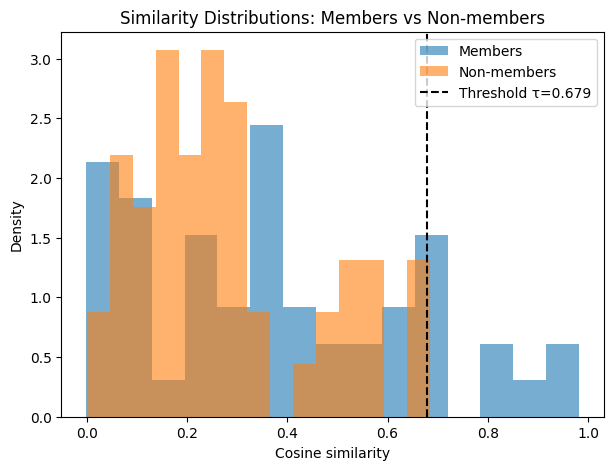

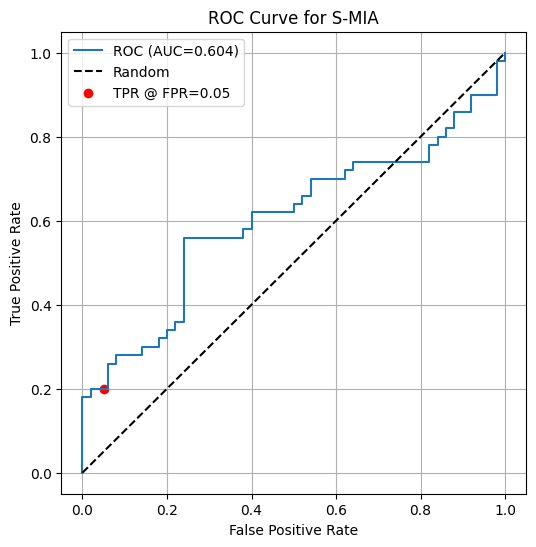


[Eval S-MIA] Top-5 highest-scoring MEMBERS:

Member #15 | score=0.9819
Query: President OKs More Colombia Assistance (AP) AP - President Bush said Tuesday the ...
Answer (true): U.S. government will continue to assist Colombia in interdicting aircraft suspected of drug trafficking. ...

Member #16 | score=0.9262
Query: Nadal Wins in Poland for First ATP Title (AP) AP - Spain's Rafael Nadal won his first ...
Answer (true): ATP singles title Sunday, beating Argentina's Jose Acasuso 6-3, 6-4 in the final at the Idea Prokom Open. ...

Member #43 | score=0.8892
Query: News: Warmer Weather, Human Disturbances Interact to Change Forests While a rapidly changing climate may alter the composition of northern Wisconsin's forests, ...
Answer (true): disturbances such as logging also will play a critical role in how these sylvan ecosystems change over time. (University of Wisconsin-Madison press release) ...

Member #21 | score=0.8325
Query: Free-Speech Protection Sought for Internet Casino Ads B

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

[RAG] Loading LLM (Flan-T5-small)...


Device set to use cpu


[Eval S-MIA] Computing similarities (this may take some time)...
  Processed 100/100
[Eval S-MIA] Results:
  AUC                     = 0.629
  TPR at 5.0% FPR = 28.000%
  Threshold tau           = 0.5338

[Eval S-MIA] Confusion Matrix (rows: true [0,1], cols: pred [0,1])
[[48  2]
 [37 13]]
  TN=48, FP=2, FN=37, TP=13


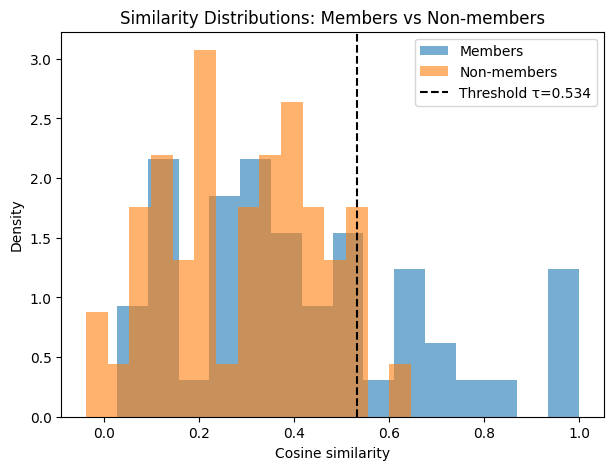

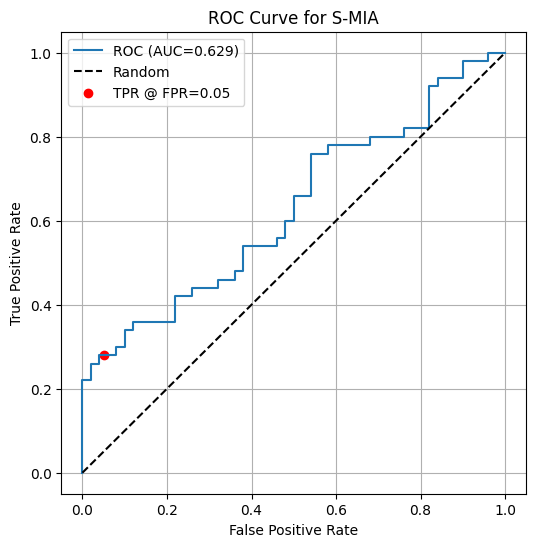


[Eval S-MIA] Top-5 highest-scoring MEMBERS:

Member #30 | score=1.0000
Query: Nearly 10 Million Afghans to Embrace Democracy KABUL (Reuters) - Thousands of U.S. troops in Afghanistan may have failed to catch ...
Answer (true): Osama bin Laden but they are credited with encouraging millions of Afghans to register for the country's historic election in October. ...

Member #10 | score=0.9727
Query: Missing June Deals Slow to Return for Software Cos. NEW YORK (Reuters) - The mystery of what went wrong for the software industry in late ...
Answer (true): June when sales stalled at more than 20 brand-name companies is not even close to being solved although the third quarter is nearly halfway over. ...

Member #0 | score=0.9583
Query: China #39;s Appeal to North Korea: Attend Nuclear Working Talks China has asked that North ...
Answer (true): Korea attend working-level meetings ahead of the next round of six-party nuclear talks in Beijing. ...

Member #4 | score=0.9385
Query: Hungry world 

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

[RAG] Loading LLM (Flan-T5-small)...


Device set to use cpu


[Eval S-MIA] Computing similarities (this may take some time)...
  Processed 100/100
[Eval S-MIA] Results:
  AUC                     = 0.667
  TPR at 5.0% FPR = 16.000%
  Threshold tau           = 0.7464

[Eval S-MIA] Confusion Matrix (rows: true [0,1], cols: pred [0,1])
[[48  2]
 [43  7]]
  TN=48, FP=2, FN=43, TP=7


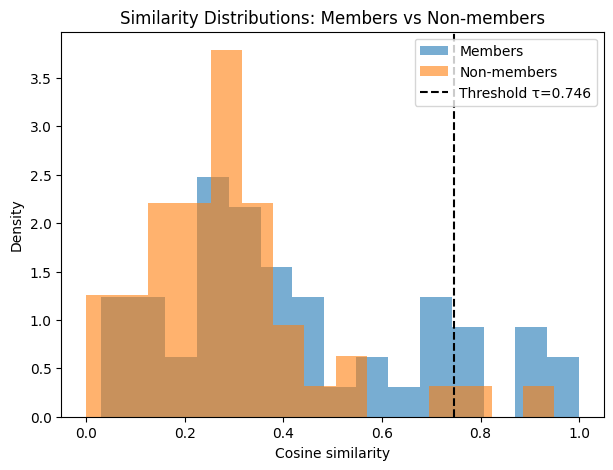

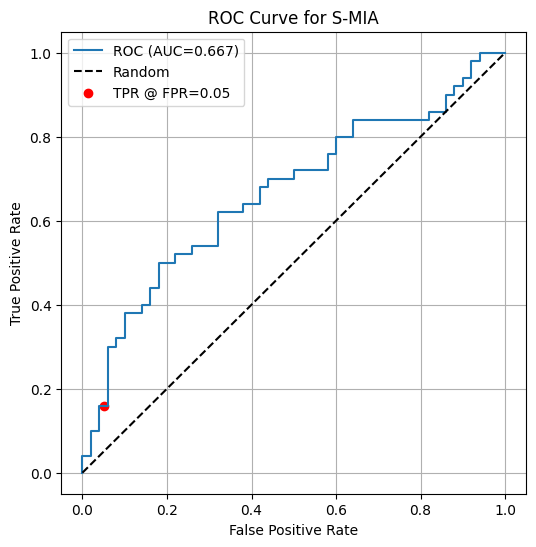


[Eval S-MIA] Top-5 highest-scoring MEMBERS:

Member #25 | score=1.0000
Query: Blast in Gaza Home of Hamas Man Kills 4 - Medics GAZA (Reuters) - An explosion tore through the home of a ...
Answer (true): senior Hamas militant in Gaza on Wednesday, killing at least four people and wounding him and about a dozen other Palestinians, medics said. ...

Member #4 | score=0.9662
Query: A gold medal in the ratings Olympic laurels. NBC swept the Nielsen ratings medals, with its first three nights of coverage ...
Answer (true): in Athens taking the top three prime-time spots last week (Aug. 9-15) in viewers and advertiser-coveted young adults. The surge ... ...

Member #47 | score=0.9283
Query: Hearing clue to whale evolution The evolution of whales from four-legged land ...
Answer (true): dwellers into streamlined swimmers has been traced in fossilised ears, Nature reports. ...

Member #31 | score=0.9203
Query: Czech Coach Hlinka Dies in Car Accident (AP) AP - Czech Republic national ice hockey

In [3]:
import math
import random
from dataclasses import dataclass
from typing import List, Dict
import numpy as np
import torch
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
import faiss
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt


# ============================================================
# 0. CONFIG
# ============================================================

@dataclass
class RAGConfig:
    llm_name: str = "google/flan-t5-small"
    retriever_model: str = "sentence-transformers/all-MiniLM-L6-v2"
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    top_k: int = 2
    max_new_tokens: int = 64
    seed: int = 42


@dataclass
class AttackConfig:
    num_members_in_kb: int = 300       # KB size
    num_eval_members: int = 50        # eval members
    num_eval_nonmembers: int = 50     # eval non-members
    target_fpr: float = 0.05          # FPR for threshold


# ============================================================
# 1. UTILS
# ============================================================

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    a_norm = a / (np.linalg.norm(a) + 1e-8)
    b_norm = b / (np.linalg.norm(b) + 1e-8)
    return float(np.dot(a_norm, b_norm))


def best_threshold_at_fpr(scores: np.ndarray,
                          labels: np.ndarray,
                          target_fpr: float = 0.01) -> float:
    fpr, tpr, thresholds = roc_curve(labels, scores)
    idx = np.where(fpr <= target_fpr)[0]
    if len(idx) == 0:
        return thresholds[0]
    best_idx = idx[np.argmax(tpr[idx])]
    return thresholds[best_idx]


# ============================================================
# 2. DATA
# ============================================================

def load_agnews_for_rag(max_samples: int = 3000) -> List[Dict]:
    print("[Main] Loading AgNews samples...")
    dataset = load_dataset("fancyzhx/ag_news", split=f"train[:{max_samples}]")

    samples = []
    for item in dataset:
        text = item["text"]
        words = text.split()
        if len(words) < 10:
            continue
        mid = len(words) // 2
        q = " ".join(words[:mid])
        a = " ".join(words[mid:])
        samples.append({"query": q, "answer": a})

    print(f"[Main] Total usable samples: {len(samples)}")
    return samples


def split_for_attack(samples: List[Dict], cfg: AttackConfig):
    assert len(samples) > cfg.num_members_in_kb + cfg.num_eval_members + cfg.num_eval_nonmembers

    random.shuffle(samples)

    kb_members = samples[:cfg.num_members_in_kb]

    offset = cfg.num_members_in_kb
    eval_members = kb_members[:cfg.num_eval_members]
    eval_nonmembers = samples[offset:offset + cfg.num_eval_nonmembers]

    return kb_members, eval_members, eval_nonmembers


# ============================================================
# 3. RAG SYSTEM
# ============================================================

class RAGSystem:
    def __init__(self, config: RAGConfig, kb_samples: List[Dict]):
        self.cfg = config

        print("[RAG] Loading retriever model...")
        self.retriever = SentenceTransformer(self.cfg.retriever_model, device=self.cfg.device)

        print("[RAG] Building KB embeddings...")
        self.kb_texts = [s["answer"] for s in kb_samples]
        self.kb_embeddings = self.retriever.encode(
            self.kb_texts,
            show_progress_bar=True,
            convert_to_numpy=True
        )

        d = self.kb_embeddings.shape[1]
        faiss.normalize_L2(self.kb_embeddings)
        self.index = faiss.IndexFlatIP(d)
        self.index.add(self.kb_embeddings)

        print("[RAG] Loading LLM (Flan-T5-small)...")
        self.tokenizer = AutoTokenizer.from_pretrained(self.cfg.llm_name)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(self.cfg.llm_name).to(self.cfg.device)
        self.generator = pipeline(
            "text2text-generation",
            model=self.model,
            tokenizer=self.tokenizer,
            device=0 if self.cfg.device == "cuda" else -1
        )

        self.sim_embedder = self.retriever

    def retrieve(self, query: str, top_k: int = None):
        if top_k is None:
            top_k = self.cfg.top_k
        q_emb = self.retriever.encode([query], convert_to_numpy=True)
        faiss.normalize_L2(q_emb)
        D, I = self.index.search(q_emb, top_k)
        retrieved = [self.kb_texts[i] for i in I[0]]
        return retrieved

    def build_prompt(self, query: str) -> str:
        context_docs = self.retrieve(query, self.cfg.top_k)
        context = "\n\n".join(context_docs)
        prompt = (
            "You are a helpful assistant. Answer the question using the context.\n\n"
            f"Context:\n{context}\n\n"
            f"Question:\n{query}\n\n"
            "Answer:"
        )
        return prompt

    def generate_answer(self, query: str) -> str:
        prompt = self.build_prompt(query)
        out = self.generator(
            prompt,
            max_new_tokens=self.cfg.max_new_tokens,
        )[0]["generated_text"]
        return out.strip()

    def answer_similarity(self, query: str, ground_truth: str) -> float:
        gen = self.generate_answer(query)
        emb_gt = self.sim_embedder.encode([ground_truth], convert_to_numpy=True)[0]
        emb_gen = self.sim_embedder.encode([gen], convert_to_numpy=True)[0]
        return cosine_similarity(emb_gen, emb_gt)


# ============================================================
# 4. S-MIA + ANALYSIS
# ============================================================

def evaluate_s_mia_with_analysis(
    target_rag: RAGSystem,
    eval_members: List[Dict],
    eval_nonmembers: List[Dict],
    target_fpr: float = 0.05
):
    eval_all = [(s, 1) for s in eval_members] + [(s, 0) for s in eval_nonmembers]

    sims = []
    labels = []

    print("[Eval S-MIA] Computing similarities (this may take some time)...")
    for i, (sample, y) in enumerate(eval_all):
        sim = target_rag.answer_similarity(sample["query"], sample["answer"])
        sims.append(sim)
        labels.append(y)
        print(f"  Processed {i+1}/{len(eval_all)}", end="\r")

    sims = np.array(sims)
    labels = np.array(labels)

    # threshold
    tau = best_threshold_at_fpr(sims, labels, target_fpr=target_fpr)
    preds = (sims > tau).astype(int)

    # metrics
    auc = roc_auc_score(labels, sims)
    fpr, tpr, roc_thresholds = roc_curve(labels, sims)
    idx = np.where(fpr <= target_fpr)[0]
    tpr_at_target = tpr[idx[-1]] if len(idx) > 0 else 0.0

    print("\n[Eval S-MIA] Results:")
    print(f"  AUC                     = {auc:.3f}")
    print(f"  TPR at {target_fpr*100:.1f}% FPR = {tpr_at_target*100:.3f}%")
    print(f"  Threshold tau           = {tau:.4f}")

    # ---------- Confusion matrix ----------
    cm = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    print("\n[Eval S-MIA] Confusion Matrix (rows: true [0,1], cols: pred [0,1])")
    print(cm)
    print(f"  TN={tn}, FP={fp}, FN={fn}, TP={tp}")

    # ---------- Member vs Non-member scores ----------
    n_mem = len(eval_members)
    member_scores = sims[:n_mem]
    nonmember_scores = sims[n_mem:]

    # ---------- Plot similarity histograms ----------
    plt.figure(figsize=(7, 5))
    plt.hist(member_scores, bins=15, alpha=0.6, label="Members", density=True)
    plt.hist(nonmember_scores, bins=15, alpha=0.6, label="Non-members", density=True)
    plt.axvline(tau, color="k", linestyle="--", label=f"Threshold τ={tau:.3f}")
    plt.xlabel("Cosine similarity")
    plt.ylabel("Density")
    plt.title("Similarity Distributions: Members vs Non-members")
    plt.legend()
    plt.show()

    # ---------- Plot ROC curve ----------
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.scatter([target_fpr], [tpr_at_target], color="red",
                label=f"TPR @ FPR={target_fpr:.2f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for S-MIA")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ---------- Show top-5 highest-scoring members & non-members ----------
    print("\n[Eval S-MIA] Top-5 highest-scoring MEMBERS:")
    member_indices_sorted = np.argsort(-member_scores)  # descending
    for rank in range(min(5, len(member_indices_sorted))):
        idx_mem = member_indices_sorted[rank]
        s = eval_members[idx_mem]
        print(f"\nMember #{idx_mem} | score={member_scores[idx_mem]:.4f}")
        print("Query:", s['query'][:200], "...")
        print("Answer (true):", s['answer'][:200], "...")

    print("\n[Eval S-MIA] Top-5 highest-scoring NON-MEMBERS:")
    nonmember_indices_sorted = np.argsort(-nonmember_scores)
    for rank in range(min(5, len(nonmember_indices_sorted))):
        idx_non = nonmember_indices_sorted[rank]
        s = eval_nonmembers[idx_non]
        print(f"\nNon-member #{idx_non} | score={nonmember_scores[idx_non]:.4f}")
        print("Query:", s['query'][:200], "...")
        print("Answer (true):", s['answer'][:200], "...")

    return {
        "auc": auc,
        "tpr_at_fpr": tpr_at_target,
        "tau": tau,
        "scores": sims,
        "labels": labels,
        "preds": preds,
    }


# ============================================================
# 5. ONE-RUN PIPELINE (FOR A GIVEN SEED)
# ============================================================

def run_single_seed(seed: int, rag_cfg: RAGConfig, attack_cfg: AttackConfig, samples: List[Dict]):
    print(f"\n================= SEED {seed} =================")
    set_seed(seed)

    print("[Main] Splitting data for KB and evaluation...")
    kb_members, eval_members, eval_nonmembers = split_for_attack(samples.copy(), attack_cfg)

    print(f"[Main] KB size: {len(kb_members)}")
    print(f"[Main] Eval members: {len(eval_members)}")
    print(f"[Main] Eval non-members: {len(eval_nonmembers)}")

    print("[Main] Building target RAG...")
    target_rag = RAGSystem(rag_cfg, kb_members)

    results = evaluate_s_mia_with_analysis(
        target_rag,
        eval_members,
        eval_nonmembers,
        target_fpr=attack_cfg.target_fpr
    )
    print("[Main] Done for this seed.")
    return results


# ============================================================
# 6. MULTI-SEED EXPERIMENT
# ============================================================

def run_multi_seed_experiment():
    rag_cfg = RAGConfig()
    attack_cfg = AttackConfig()

    samples = load_agnews_for_rag(max_samples=3000)

    seeds = [42, 43, 44]  # you can add more if Colab can handle it
    aucs = []
    tprs = []

    for s in seeds:
        res = run_single_seed(s, rag_cfg, attack_cfg, samples)
        aucs.append(res["auc"])
        tprs.append(res["tpr_at_fpr"])

    aucs = np.array(aucs)
    tprs = np.array(tprs)

    print("\n================= MULTI-SEED SUMMARY =================")
    print(f"Seeds: {seeds}")
    print(f"AUC mean ± std       = {aucs.mean():.3f} ± {aucs.std():.3f}")
    print(f"TPR@{attack_cfg.target_fpr*100:.1f}%FPR mean ± std = {tprs.mean()*100:.2f}% ± {tprs.std()*100:.2f}%")


# ============================================================
# 7. MAIN
# ============================================================

if __name__ == "__main__":
    run_multi_seed_experiment()
